## Supervised Learning
## Project: Finding Donors for *CharityML*

Note: Sections that begin with **'Implementation'** in the header indicate that the following block of code requires additional functionality.  In addition to implementing code, there are questions that with their answers, which relate to the project and my implementation.

## Getting Started

In this project, I employed several supervised algorithms of my choice to accurately model individuals' income using data collected from the 1994 U.S. Census. I then chose the best candidate algorithm from preliminary results and further optimized this algorithm to best model the data. My goal with this implementation, was to construct a model that accurately predicts whether or not an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
I Loaded the necessary Python libraries as well as the census data. The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline


# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

ModuleNotFoundError: No module named 'visuals'


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, I computed the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [2]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data [data['income'] == '>50K'])


# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data [data['income'] == '<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = round((n_greater_50k/n_records) * 100, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


**Features**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

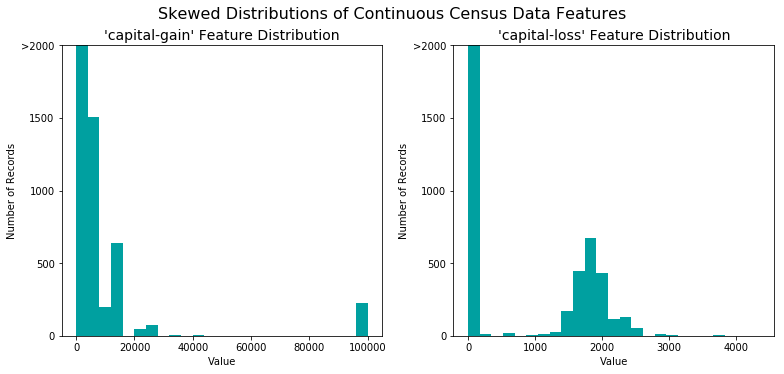

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

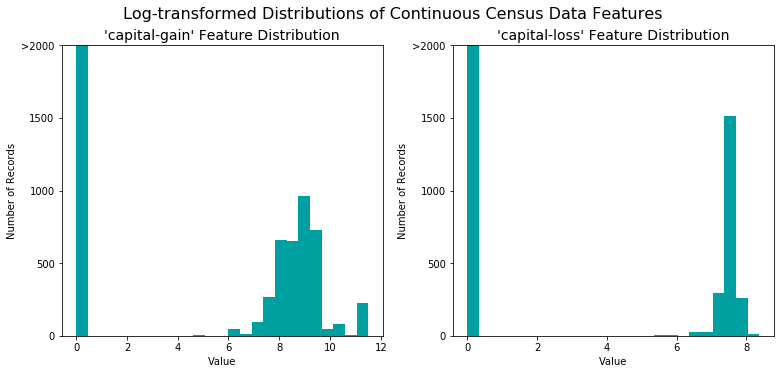

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. 
In code cell below, I implemented the following:
 - Used [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Converted the target label `'income_raw'` to numerical entries.
   - Rrecords set with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
from pandas import get_dummies

#from sklearn.preprocessing import OneHotEncoder

features_final = get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x : 0 if (x == '>50K') else 1)
#OneHotEncoder(income_raw)
#income.fit_transform(income_raw)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

In [7]:
income.head( n=16 )

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     0
8     0
9     0
10    0
11    0
12    1
13    1
14    1
15    1
Name: income, dtype: int64

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [ ]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of my choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 
The code cell below has the assigned results of `'accuracy'` and `'fscore'` to be used later.

**Please note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally the base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from. 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [13]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data  encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case
TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''

from sklearn.metrics import accuracy_score 

TP = np.sum(income)
FP = income.count() - TP
TN = 0
FN = 0

# Calculate accuracy, precision and recall
accuracy = n_greater_50k / n_records
recall = n_greater_50k / n_greater_50k
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + (0.5*0.5)) * ((precision*recall) / ((precision*0.5*0.5)+recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that I had to choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### 2 - Model Application
I Listed three of the supervised learning models above I thought were appropriate for this problem. 
For each model chosen I:

- Described one real-world application in industry where the model can be applied. 
- Described the strengths of the model; when it performs well.
- Described the weaknesses of the model; when it performs poorly.
- Described the What makes this model a good candidate for the problem.

**Models I used**

1. Random forest.

**Real world application:** Random Forest is used in Classification and Regression problems. For instance, it is used to Predict Cardiovascular Disease, in search ranking and to detect bitcoin price.

**Strengths of the model:** Handles continuous and categorical data well, as well as working well on a large datasets and being insensitive to outliers.

**Weaknesses of the model:** Prone to overfitting, and many times tuning is a must.

**What makes this model a good candidate:** Random Forest works with enormous datasets, and assures fast identification of significant information. As it is a collection of many decision trees, and is simple I think it is a good fit for our project, as we have many features(dependant variable).

- References: https://towardsai.net/p/machine-learning/why-choose-random-forest-and-not-decision-trees , https://iq.opengenus.org/applications-of-random-forest/ , https://towardsai.net/p/machine-learning/why-choose-random-forest-and-not-decision-trees


2. Decision trees.

**Real world application:** Decision Trees are flexible, and therefore used in many fields such as healthcare and financial planning. For example, using factors like gender. age, symptoms, etc., emergency room triage has the ability to prioritize patient care.

**Strengths of the model:**  Not only can decision Trees be used for both regression and classification problems, it can also handle both categorical and continuous variables.


**Weaknesses of the model:** Decision tree often leads to overfitting, which consequently leads to high variance.

**What makes this model a good candidate:** Decison trees can handle both numerical and categorical data, thus fitting our dataset well. 

- References: https://careerfoundry.com/en/blog/data-analytics/what-is-a-decision-tree/ , http://theprofessionalspoint.blogspot.com/2019/02/advantages-and-disadvantages-of.html


3. Gradient Boosting.

**Real world application:** Gradient Boosting is used in data mining(Learning to rank), for example Yahoo's search engines use variants of gradient boosting.

**Strengths of the model:** Highly accurate and flexible.

**Weaknesses of the model:** May overfit when data is too noisy.

**What makes this model a good candidate:** Since several weak learners are merged to create a new and improved model, Gradient Boosting seems to be a good choice to go with. Also our data is kind of simple, and free of noise.

- References: https://www.baeldung.com/cs/gradient-boosting-trees-vs-random-forests , https://en.wikipedia.org/wiki/Gradient_boosting

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model I've chosen, it's important to create a training and predicting pipeline that allows quick and effective training of models, using various sizes of training data and perform predictions on the testing data.
In the code block below, you I implemented the following:
 - Imported `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fitted the learner to the sampled training data and recorded the training time.
 - Performed predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
 - Calculated the accuracy score for both the training subset and testing set.
 - Calculated the F-score for both the training subset and testing set.

In [10]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:300], y_train[:300])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test), then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, I implemented the following:
- Imported the three supervised learning models I've discussed in the previous section.
- Initialized the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
- Calculated the number of records equal to 1%, 10%, and 100% of the training data.

DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


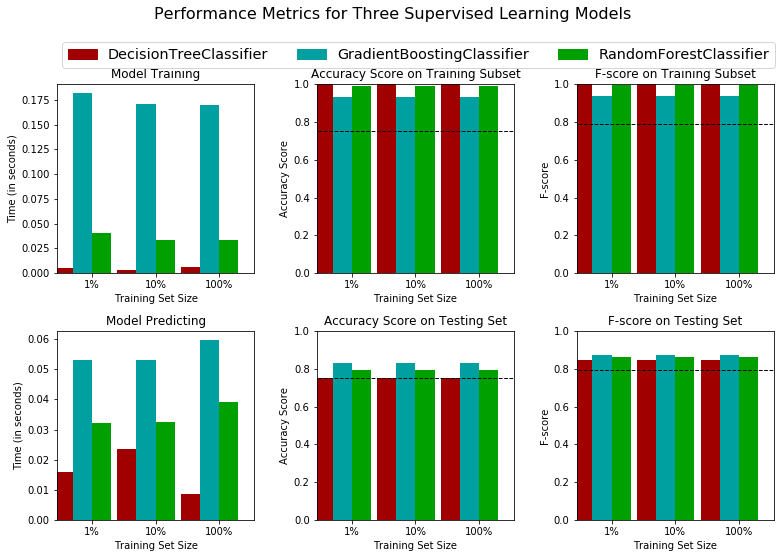

In [11]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the three models
clf_A = DecisionTreeClassifier(random_state = 0)
clf_B = GradientBoostingClassifier(random_state = 0)
clf_C = RandomForestClassifier(random_state = 0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# Samples_100 is the entire training set i.e. len(y_train)
# Samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# Samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = X_train.shape[0]
samples_10 = int(len(X_train) / 10)
samples_1 = int(len(X_train) / 100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [12]:
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

DecisionTreeClassifier


,1%,10%,100%
acc_test,0.752239,0.752239,0.752239
acc_train,1.000000,1.000000,1.000000
f_test,0.845926,0.845926,0.845926
f_train,1.000000,1.000000,1.000000
pred_time,0.015815,0.023621,0.008556
train_time,0.004838,0.002800,0.006716


GradientBoostingClassifier


,1%,10%,100%
acc_test,0.829077,0.829077,0.829077
acc_train,0.933333,0.933333,0.933333
f_test,0.874000,0.874000,0.874000
f_train,0.936469,0.936469,0.936469
pred_time,0.053046,0.053165,0.059762
train_time,0.181694,0.170544,0.169703


RandomForestClassifier


,1%,10%,100%
acc_test,0.792040,0.792040,0.792040
acc_train,0.990000,0.990000,0.990000
f_test,0.861147,0.861147,0.861147
f_train,0.994718,0.994718,0.994718
pred_time,0.032037,0.032632,0.039175
train_time,0.040208,0.033434,0.033710


----
## Improving Results
In this final section, I choose from the three supervised learning models the *best* model to use on the student data. I then performed a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning parameters to improve upon the untuned model's F-score. 

### 3 - Choosing the Best Model

* Based on the evaluation I performed earlier, I explained to *CharityML* which of the three models I believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

My disscussion consisted of:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

According to the results, when 100% of the training data is used, Gradient Boosting is the one with the highest F-score, though the other two are not that far behind. On the other hand, when it came to the training data results, Decision tree and Random Forest had the highest F score, while Gradient Boosting was a bit behind. Regarding time, Gradient Boosting too the longest for both model training and predictin. Decision Tree seems to be the fastest for both training and predicting.

In conclusion, I believe that the algorithm most appropriate for the data is Random Forest for various reasons. First off, it takes an acceptable amount of time when predicting and training. Secondly, it may not have the highets F score for testing  data, but for training data its F score is certainly the highest. Finally, Random Forest's accuracy for both training data and test data are pretty high, which is a good sign.

### 4 - Describing the Model in Layman's Terms

The model I am using is Random Forest. It basically is an algorithm that contains many Decision Trees, working as a group. Each individual tree, produces a class prediction and the class that most trees agree on becomes the model’s prediction.


- references: https://towardsdatascience.com/understanding-random-forest-58381e0602d2

### Implementation: Model Tuning
To fine tune the chosen model, I Used grid search (`GridSearchCV`).

In the code cell below, I implemented the following:
- Imported [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialized the classifier I've chosen and stored it in `clf`.
- Created a dictionary of parameters to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Used `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Performed grid search on the classifier `clf` using the `'scorer'`, and stored it in `grid_obj`.
- Fitted the grid search object to the training data (`X_train`, `y_train`), and stored it in `grid_fit`.

In [13]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = RandomForestClassifier(random_state = 0)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'criterion': ['gini', 'entropy'],
 'max_depth': [2, 4, 6],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [10, 20, 30, 100]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8347
F-score on testing data: 0.8899

Optimized Model
------
Final accuracy score on the testing data: 0.8451
Final F-score on the testing data: 0.8740


### 5 - Final Model Evaluation

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8347      |       0.8451    |
| F-score        |       0.8899      |       0.8740    |

The optimized model has an accuracy of 0.8451 and F-score of 0.8740.
These scores are better than those of the umpotimized model, and definitely surpassed those of the naive predictor benchmarks.


## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

In the next python cell I fitted a classifie, with a `feature_importance_` attributer, to training set and used this attribute to determine the top 5 most important features for the census dataset.

### 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. These are the five features most important for prediction, accoring to my own beliefs.

1. Capital gain: Financial stability can be guessed from profit.
2. occupation: Payscales differ according to the job, so it is important in identifying the probability that the person will donate.
3. education: The higher the education, the better the individual is at more advanced jobs, thus a higher paycheck. 
4. workclass: Depends on what they do and their salary, but it is much better than a student who has no extra money to donate.
5. age: As people get older their wealth increases, and they probably do not have much use for their extra money.

I ranked them according the the impact they have on an individual's income. Number one is Captial gain, as if it is relatively high, none of the others would matter as much.

### Implementation - Extracting Feature Importance
I used a `scikit-learn` supervised learning algorithm with a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, I implemented the following:
 - Trained the supervised model on the entire training set.
 - Extracted the feature importances using `'.feature_importances_'`.

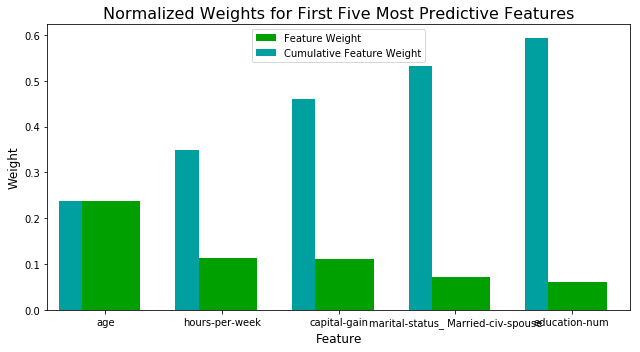

In [14]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train,y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

###  7 - Extracting Feature Importance

Observing the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000, I stated:
* How these five features compared to the five features I discussed in **'6'**?
* How this visualization confirmed my thoughts? 
* Why do I thought the features I have used were more relevant?

Of the five features predicted in the earlier section, only 3 features made it through to the list of features considered most important by Random Forest; age, capital gain, and education, but the rankings are different.

It came as a surprise to me that age is the most important as my hypothesis stated that it would be last. But as I assumed capital gain is more important than education, though not by much.

I thought about maybe adding marital status, as single men and women have much less responsibilities, thus the possibility of having extra cash lying around, but it did not seem as important as the ones I added. Same goes to hours per week, as I thought that not always do they control income.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [15]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8451
F-score on testing data: 0.8740

Final Model trained on reduced data
------
Accuracy on testing data: 0.8436
F-score on testing data: 0.8738


### 8 - Effects of Feature Selection

I stated:
* How the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used.
* If I would consider using the reduced data as my training set, if training time was a factor.

Using only the aforementioned features, both accuracy and f score decreased,though not by much. Consequently, I would not like to use he reduced data as my training set. But, if training time was a factor maybe I would consider using it as the model can be trained more than it would have with the larger number of features.